# Library

In [1]:
import gc # Garbage collector

import pandas as pd
import numpy as np

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import accuracy_score, auc, ConfusionMatrixDisplay, confusion_matrix, classification_report

# Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

SEED=2022
NSPLITS = 5
SHUFFLE =True


Decile Analysis 

In [2]:

def decile_table(y_true, y_prob, labels=True, round_decimal=3):
   
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    df = pd.DataFrame()
    df['y_true'] = y_true
    df['y_prob'] = y_prob
    
    df.sort_values('y_prob', ascending=False, inplace=True)
    df['decile'] = np.linspace(1, 11, len(df), False, dtype=int)

    dt = df.groupby('decile').apply(lambda x: pd.Series([
        np.min(x['y_prob']),
        np.max(x['y_prob']),
        np.mean(x['y_prob']),
        np.size(x['y_prob']),
        np.sum(x['y_true']),
        np.size(x['y_true'][x['y_true'] == 0]),
    ],
        index=(["prob_min", "prob_max", "prob_avg",
                "cnt_cust", "cnt_resp", "cnt_non_resp"])
    )).reset_index()

    dt['prob_min']=dt['prob_min'].round(round_decimal)
    dt['prob_max']=dt['prob_max'].round(round_decimal)
    dt['prob_avg']=round(dt['prob_avg'],round_decimal)
    

    tmp = df[['y_true']].sort_values('y_true', ascending=False)
    tmp['decile'] = np.linspace(1, 11, len(tmp), False, dtype=int)

    dt['cnt_resp_rndm'] = np.sum(df['y_true']) / 10
    dt['cnt_resp_wiz'] = tmp.groupby('decile', as_index=False)['y_true'].sum()['y_true']

    dt['cum_resp'] = np.cumsum(dt['cnt_resp'])
    dt['cum_resp_wiz'] = np.cumsum(dt['cnt_resp_wiz'])
    dt['cum_resp_pct'] = round(dt['cum_resp'] * 100 / np.sum(dt['cnt_resp']), round_decimal)
    dt['cum_resp_pct_wiz'] = round(dt['cum_resp_wiz'] * 100 / np.sum(dt['cnt_resp_wiz']), round_decimal)


    if labels is True:
        print_labels()

    return dt[['decile', 'cum_resp_pct', 'cum_resp_pct_wiz']]

def area_ratio(pcg):
    # Area of the model 
    area_model = auc(np.append(0, pcg.decile.values), np.append(0, pcg.cum_resp_pct.values))
    area_base = auc(np.append(np.arange(0, 100, 10), 100), np.append(np.arange(0, 10, 1), 10))
    diff_base_model = area_model - area_base
    area_wizard = auc(np.append(0, pcg.decile.values), np.append(0, pcg.cum_resp_pct_wiz.values))
    diff_wizard_base = area_wizard - area_base
    area_ratio = diff_base_model / diff_wizard_base
    return area_ratio

def plot_lift_chart(pcg, area_ratio, title='Cumulative Gain Plot',
                         title_fontsize=14, text_fontsize=10, figsize=None):

    plt.plot(np.append(0, pcg.decile.values), np.append(0, pcg.cum_resp_pct.values), marker='o', label='Model')
    plt.plot(np.append(0, pcg.decile.values), np.append(0, pcg.cum_resp_pct_wiz.values), 'c--', label='Best curve')
    plt.plot([0, 10], [0, 100], 'k--', marker='o', label='Baseline')
    plt.text(4, 30, f"Area ratio: {area_ratio}")
    plt.title(title, fontsize=title_fontsize)
    plt.xlabel('Deciles', fontsize=text_fontsize)
    plt.ylabel('% Cumulative number of target data', fontsize=text_fontsize)
    plt.legend(borderpad=1)
    plt.grid(True)
    

def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        # Add '_FE' to differentiate new column from old ones
        nm = col+'_FE'
        # Map the frequency vector using the modality of the respective column
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        
def encode_AG(main_columns, groups, aggregations, train_df, test_df):
  
    for main_column in main_columns:  
        for col in groups:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                                
encode_aggregate_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
main_features = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [3]:
defaultcard = pd.read_csv('UCI_Credit_Card.csv')
defaultcard.drop(columns='ID', inplace=True)
defaultcard.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
defaultcard.rename(columns={'default.payment.next.month':'target', 'PAY_0':'PAY_1'}, inplace=True)
defaultcard.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [5]:
defaultcard['target'].value_counts()

target
0    23364
1     6636
Name: count, dtype: int64

In [6]:
defaultcard = defaultcard.drop_duplicates(subset=[col for col in defaultcard.columns if col != 'target'])
defaultcard.shape

(29944, 24)

In [7]:
defaultcard.shape

(29944, 24)

# Removing outliers using boxplot formula

In [8]:
# Select defaulters observations
df_targets = defaultcard[defaultcard['target'] == 1]

# Remove outliers for the 'LIMT_BAL' variable
q1 = df_targets['LIMIT_BAL'].quantile(0.25) # First quartile
q3 = df_targets['LIMIT_BAL'].quantile(0.75) # Third quartile
iqr = q3 - q1 # Interquartile range
# Filter outlier observation and take their index
filtration = (df_targets['LIMIT_BAL'] < q1 - 1.5 * iqr) | (df_targets['LIMIT_BAL'] > q3 + 1.5 *iqr)
df_target_index1 = list(df_targets.loc[filtration].index)
df_targets = df_targets.loc[~filtration]


# Remove outliers for the 'BILL_AMT1' variable
q1 = df_targets['BILL_AMT1'].quantile(0.25) # First quartile
q3 = df_targets['BILL_AMT1'].quantile(0.75) # Third quartile
iqr = q3 - q1 # Interquartile range
# Filter outlier observation and take their index
filtration = (df_targets['BILL_AMT1'] < q1 - 1.5 * iqr) | (df_targets['BILL_AMT1'] > q3 + 1.5 *iqr)
df_target_index2 = list(df_targets.loc[filtration].index)
df_targets = df_targets.loc[~filtration]

# Remove outliers for the 'BILL_AMT2' variable
q1 = df_targets['BILL_AMT2'].quantile(0.25) # First quartile
q3 = df_targets['BILL_AMT2'].quantile(0.75) # Third quartile
iqr = q3 - q1 # Interquartile range
# Filter outlier observation and take their index
filtration = (df_targets['BILL_AMT2'] < q1 - 1.5 * iqr) | (df_targets['BILL_AMT2'] > q3 + 1.5 *iqr)
df_target_index3 = list(df_targets.loc[filtration].index)
df_targets = df_targets.loc[~filtration]


# Remove outliers for the 'BILL_AMT3' variable
q1 = df_targets['BILL_AMT3'].quantile(0.25) # First quartile
q3 = df_targets['BILL_AMT3'].quantile(0.75) # Third quartile
iqr = q3 - q1 # Interquartile range
# Filter outlier observation and take their index
filtration = (df_targets['BILL_AMT3'] < q1 - 1.5 * iqr) | (df_targets['BILL_AMT3'] > q3 + 1.5 *iqr)
df_target_index4 = list(df_targets.loc[filtration].index)
df_targets = df_targets.loc[~filtration]

# Remove outliers for the 'BILL_AMT4' variable
q1 = df_targets['BILL_AMT4'].quantile(0.25) # First quartile
q3 = df_targets['BILL_AMT4'].quantile(0.75) # Third quartile
iqr = q3 - q1 # Interquartile range
# Filter outlier observation and take their index
filtration = (df_targets['BILL_AMT4'] < q1 - 1.5 * iqr) | (df_targets['BILL_AMT4'] > q3 + 1.5 *iqr)
df_target_index5 = list(df_targets.loc[filtration].index)
df_targets = df_targets.loc[~filtration]

# Remove outliers for the 'BILL_AMT5' variable
q1 = df_targets['BILL_AMT5'].quantile(0.25) # First quartile
q3 = df_targets['BILL_AMT5'].quantile(0.75) # Third quartile
iqr = q3 - q1 # Interquartile range
# Filter outlier observation and take their index
filtration = (df_targets['BILL_AMT5'] < q1 - 1.5 * iqr) | (df_targets['BILL_AMT5'] > q3 + 1.5 *iqr)
df_target_index6 = list(df_targets.loc[filtration].index)
df_targets = df_targets.loc[~filtration]

# Remove outliers for the 'BILL_AMT6' variable
q1 = df_targets['BILL_AMT6'].quantile(0.25) # First quartile
q3 = df_targets['BILL_AMT6'].quantile(0.75) # Third quartile
iqr = q3 - q1 # Interquartile range
# Filter outlier observation and take their index
filtration = (df_targets['BILL_AMT6'] < q1 - 1.5 * iqr) | (df_targets['BILL_AMT6'] > q3 + 1.5 *iqr)
df_target_index7 = list(df_targets.loc[filtration].index)
df_targets = df_targets.loc[~filtration]

# Remove outliers for the 'PAY_AMT1' variable
q1 = df_targets['PAY_AMT1'].quantile(0.25) # First quartile
q3 = df_targets['PAY_AMT1'].quantile(0.75) # Third quartile
iqr = q3 - q1 # Interquartile range
# Filter outlier observation and take their index
filtration = (df_targets['PAY_AMT1'] < q1 - 1.5 * iqr) | (df_targets['PAY_AMT1'] > q3 + 1.5 *iqr)
df_target_index8 = list(df_targets.loc[filtration].index)
df_targets = df_targets.loc[~filtration]

# Remove outliers for the 'PAY_AMT2' variable
q1 = df_targets['PAY_AMT2'].quantile(0.25) # First quartile
q3 = df_targets['PAY_AMT2'].quantile(0.75) # Third quartile
iqr = q3 - q1 # Interquartile range
# Filter outlier observation and take their index
filtration = (df_targets['PAY_AMT2'] < q1 - 1.5 * iqr) | (df_targets['PAY_AMT2'] > q3 + 1.5 *iqr)
df_target_index9 = list(df_targets.loc[filtration].index)
df_targets = df_targets.loc[~filtration]

# Remove outliers for the 'PAY_AMT3' variable
q1 = df_targets['PAY_AMT3'].quantile(0.25) # First quartile
q3 = df_targets['PAY_AMT3'].quantile(0.75) # Third quartile
iqr = q3 - q1 # Interquartile range
# Filter outlier observation and take their index
filtration = (df_targets['PAY_AMT3'] < q1 - 1.5 * iqr) | (df_targets['PAY_AMT3'] > q3 + 1.5 *iqr)
df_target_index10 = list(df_targets.loc[filtration].index)
df_targets = df_targets.loc[~filtration]

# Remove outliers for the 'PAY_AMT4' variable
q1 = df_targets['PAY_AMT4'].quantile(0.25) # First quartile
q3 = df_targets['PAY_AMT4'].quantile(0.75) # Third quartile
iqr = q3 - q1 # Interquartile range
# Filter outlier observation and take their index
filtration = (df_targets['PAY_AMT4'] < q1 - 1.5 * iqr) | (df_targets['PAY_AMT4'] > q3 + 1.5 *iqr)
df_target_index11 = list(df_targets.loc[filtration].index)
df_targets = df_targets.loc[~filtration]

# Remove outliers for the 'PAY_AMT5' variable
q1 = df_targets['PAY_AMT5'].quantile(0.25) # First quartile
q3 = df_targets['PAY_AMT5'].quantile(0.75) # Third quartile
iqr = q3 - q1 # Interquartile range
# Filter outlier observation and take their index
filtration = (df_targets['PAY_AMT5'] < q1 - 1.5 * iqr) | (df_targets['PAY_AMT5'] > q3 + 1.5 *iqr)
df_target_index12 = list(df_targets.loc[filtration].index)
df_targets = df_targets.loc[~filtration]

# Remove outliers for the 'PAY_AMT6' variable
q1 = df_targets['PAY_AMT6'].quantile(0.25) # First quartile
q3 = df_targets['PAY_AMT6'].quantile(0.75) # Third quartile
iqr = q3 - q1 # Interquartile range
# Filter outlier observation and take their index
filtration = (df_targets['PAY_AMT6'] < q1 - 1.5 * iqr) | (df_targets['PAY_AMT6'] > q3 + 1.5 *iqr)
df_target_index13 = list(df_targets.loc[filtration].index)
df_targets = df_targets.loc[~filtration]

# Remove outliers from all data
df_target_index = df_target_index1+df_target_index2+df_target_index3+df_target_index4+df_target_index5+df_target_index6+df_target_index7+df_target_index8+df_target_index9+df_target_index10+df_target_index11+df_target_index12+df_target_index13
defaultcard = defaultcard.loc[~(defaultcard.index.isin(df_target_index))]

# Delete unecessary data
del df_target_index, df_targets, df_target_index1, df_target_index2, df_target_index3, df_target_index4, df_target_index5, df_target_index6, df_target_index7, df_target_index8, df_target_index9, df_target_index10, df_target_index11, df_target_index12, df_target_index13, filtration, q1, q3, iqr
_ = gc.collect()

In [9]:
defaultcard.shape

(27052, 24)

# Remove observation that have zeros on every BILL_AMT1..6

In [10]:
# Total bill amount observation
bill_amt = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
bill_statement_sum = defaultcard[bill_amt].sum(axis=1)
print(f"Number of observation with zero total bill amount {sum(bill_statement_sum == 0)}")


bill_statement_sum_index = bill_statement_sum.loc[bill_statement_sum > 0].index
defaultcard = defaultcard.loc[bill_statement_sum_index]
defaultcard.shape

Number of observation with zero total bill amount 801


(26060, 24)

# Prepare data for training and testing

In [11]:

features_col = [col for col in defaultcard.columns if col not in ['target', 'remaining_pay_balance']]
assert len(features_col) == 23
features = defaultcard[features_col] # Features
target = defaultcard['target'] # Targets

In [12]:
# Train test split (article data)
X_train, X_test, y, y_test = train_test_split(features,
                                        target,
                                        test_size=.3,
                                        shuffle=True,
                                        random_state=SEED,
                                        stratify=target
                                        )

In [13]:
unique_train, count_train = np.unique(y, return_counts=True)
print(f"y train value counts (article data): \n {np.asanyarray((unique_train, count_train/y.shape[0])).T}")
print('\n')
unique_test, count_test = np.unique(y_test, return_counts=True)
print(f"y test value counts (article data): \n {np.asanyarray((unique_test, count_test/y_test.shape[0])).T}")

y train value counts (article data): 
 [[0.         0.86936739]
 [1.         0.13063261]]


y test value counts (article data): 
 [[0.         0.86940394]
 [1.         0.13059606]]


# KNN Algorithm

In [14]:
knn_train = X_train.copy() # Copy train data 
knn_test = X_test.copy() # Copy test data

## Data normalization

In [15]:
scaler = MinMaxScaler() # StandardScaler MinMaxScaler
scaler.fit(knn_train) # Fit scaler
# Scale train data for knn
scaled_train = scaler.transform(knn_train) 
knn_train.loc[:, features_col] = scaled_train
# Scale test data for knn
scaled_test = scaler.transform(knn_test) 
knn_test.loc[:, features_col] = scaled_test

## Prediction 



KNN error rate on train set (training): 0.11358403683806595 | KNN area ratio on train set (training): 0.72298773512368

KNN error rate on test (valid) set: 0.11115374776157583 | KNN area ratio on test (valid) set: 0.6611188207936389 

              precision    recall  f1-score   support

No defaulter       0.90      0.98      0.94      6797
   Defaulter       0.67      0.30      0.41      1021

    accuracy                           0.89      7818
   macro avg       0.78      0.64      0.68      7818
weighted avg       0.87      0.89      0.87      7818



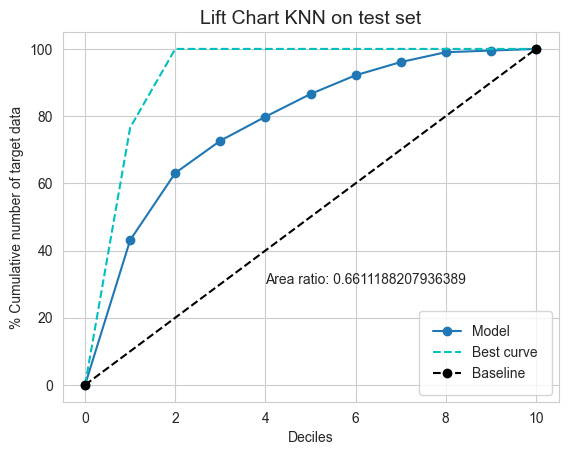

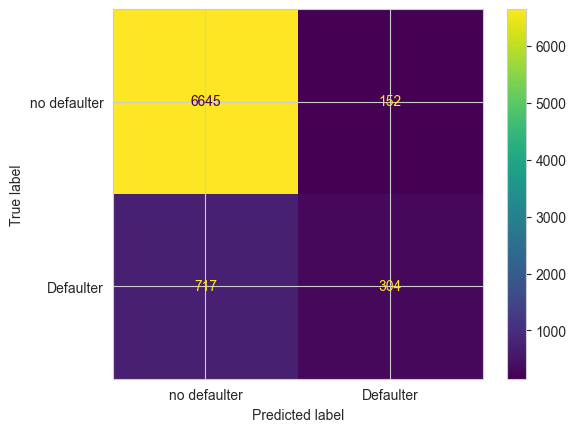

In [16]:
# Instantiation of the KNN algorithm
knn = KNeighborsClassifier(n_neighbors=35, algorithm='kd_tree', n_jobs=-1, weights='uniform')

# Train the model
knn.fit(knn_train, y)

# Predict proba & labels on the train data
train_pred11 = knn.predict(knn_train)
train_proba = knn.predict_proba(knn_train)

# Area ratio & accuracy on the train data
train_pcg = decile_table(y, train_proba[:, 1], labels=False)
area_ratio_train = area_ratio(train_pcg)
error_rate_train = 1 - accuracy_score(y, train_pred11)

# Predict proba & labels on the test data
test_pred11 = knn.predict(knn_test)
test_proba = knn.predict_proba(knn_test)

# Area ratio & accuracy on the test data
test_pcg = decile_table(y_test, test_proba[:, 1], labels=False)
error_rate_test = 1 - accuracy_score(y_test, test_pred11)
area_ratio_test = area_ratio(test_pcg)

print(f"KNN error rate on train set (training): {error_rate_train} | KNN area ratio on train set (training): {area_ratio_train}\n")
print(f"KNN error rate on test (valid) set: {error_rate_test} | KNN area ratio on test (valid) set: {area_ratio_test} \n")

# Plot lift chart
plot_lift_chart(test_pcg, area_ratio_test, title='Lift Chart KNN on test set')

# Confusion matrix
cm = confusion_matrix(y_test, test_pred11, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['no defaulter', 'Defaulter'])
# Plot confusion matrix
disp.plot()

# Classification report
print(classification_report(y_test, test_pred11, target_names=['No defaulter', 'Defaulter']))

# LDA Algorithm

In [ ]:
# Copy train & test data
lda_train = X_train.copy()
lda_test  = X_test.copy()

## Data normalization

In [ ]:
scaler.fit(lda_train) # Fit scaler
# Scale train data for logistic regression
scaled_train = scaler.transform(lda_train) 
lda_train.loc[:, features_col] = scaled_train
# Scale test data for logistic regression
scaled_test = scaler.transform(lda_test) 
lda_test.loc[:, features_col] = scaled_test

In [ ]:
# Quantitative features
real_features = [col for col in features_col if col not in ['SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6']]

# Change the distribution of the variables to normal
for col in real_features:
    qt = QuantileTransformer(random_state=21,n_quantiles=2000, output_distribution='normal')
    lda_train.loc[:, col] = qt.fit_transform(lda_train[[col]])
    lda_test.loc[:, col] = qt.transform(lda_test[[col]])    

In [ ]:
lda_train.to_csv("ldatrain")

## Predictions 

Linear Discriminant Analysis error rate on train set (training): 0.11627014581734463 | Linear Discriminant Analysis area ratio on train set (training): 0.6844255762053895

Linear Discriminant Analysis error rate on test (valid) set: 0.11307239703248917 | Linear Discriminant Analysis ratio on test (valid) set: 0.695556878703773 

              precision    recall  f1-score   support

No defaulter       0.91      0.97      0.94      6797
   Defaulter       0.63      0.33      0.43      1021

    accuracy                           0.89      7818
   macro avg       0.77      0.65      0.68      7818
weighted avg       0.87      0.89      0.87      7818



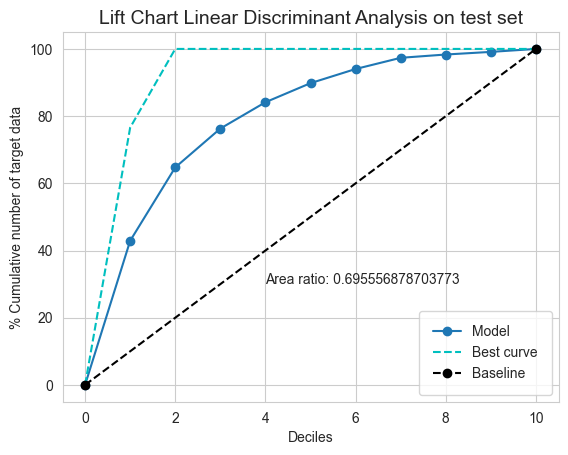

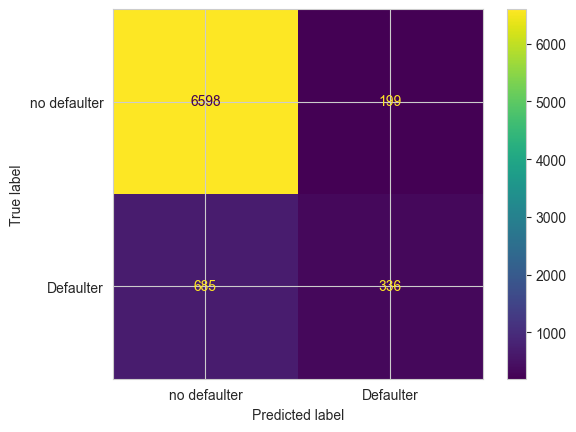

In [ ]:
# Instantiation of the Linear discriminant analysis algorithm
lda = LinearDiscriminantAnalysis()

# Train the model
lda.fit(lda_train, y)

# Predict proba & labels on the train data
train_pred = lda.predict(lda_train)
train_proba = lda.predict_proba(lda_train)

# Area ratio & accuracy on the train data
train_pcg = decile_table(y, train_proba[:, 1], labels=False)
area_ratio_train = area_ratio(train_pcg)
error_rate_train = 1 - accuracy_score(y, train_pred)

# Predict proba & labels on the test data
test_pred = lda.predict(lda_test)
test_proba = lda.predict_proba(lda_test)

# Area ratio & accuracy on the test data
test_pcg = decile_table(y_test, test_proba[:, 1], labels=False)
error_rate_test = 1 - accuracy_score(y_test, test_pred)
area_ratio_test = area_ratio(test_pcg)

print(f"Linear Discriminant Analysis error rate on train set (training): {error_rate_train} | Linear Discriminant Analysis area ratio on train set (training): {area_ratio_train}\n")
print(f"Linear Discriminant Analysis error rate on test (valid) set: {error_rate_test} | Linear Discriminant Analysis ratio on test (valid) set: {area_ratio_test} \n")

# Plot lift chart
plot_lift_chart(test_pcg, area_ratio_test, title='Lift Chart Linear Discriminant Analysis on test set')

# Confusion matrix
cm = confusion_matrix(y_test, test_pred, labels=lda.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['no defaulter', 'Defaulter'])
# Plot confusion matrix
disp.plot()

# Classification report
print(classification_report(y_test, test_pred, target_names=['No defaulter', 'Defaulter']))

# Naive Bayes (Gaussian)

In [ ]:
# Copy train & test data
nbg_train = X_train.copy()
nbg_test  = X_test.copy()

## Data normalization

In [ ]:
scaler.fit(nbg_train) # Fit scaler
# Scale train data for logistic regression
scaled_train = scaler.transform(nbg_train) 
nbg_train.loc[:, features_col] = scaled_train
# Scale test data for logistic regression
scaled_test = scaler.transform(nbg_test) 
nbg_test.loc[:, features_col] = scaled_test

In [ ]:
# Change the distribution of the variables to normal
for col in real_features:
    qt = QuantileTransformer(random_state=21,n_quantiles=2000, output_distribution='normal')
    nbg_train.loc[:, col] = qt.fit_transform(nbg_train[[col]])
    nbg_test.loc[:, col] = qt.transform(nbg_test[[col]])    

In [ ]:
nbg_train

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
13318,-0.159930,0,0.166667,0.333333,0.137931,0.2,0.2,0.2,0.2,0.2,...,0.557268,0.579525,0.589605,0.589931,-0.219051,-0.270608,-0.142173,0.065880,0.054908,-0.099576
14241,0.518941,1,0.166667,0.666667,0.189655,0.0,0.0,0.0,0.0,0.1,...,-0.871153,-0.835013,0.264945,0.267632,0.151680,-0.422258,-5.199338,1.831651,0.024203,2.295897
3470,0.015048,0,0.166667,0.666667,0.189655,0.3,0.0,0.1,0.2,0.2,...,-0.816276,-0.814764,-1.119020,-2.351962,-5.199338,0.261902,-5.199338,-5.199338,-5.199338,0.203276
16826,-1.618510,0,0.333333,0.333333,0.327586,0.2,0.2,0.2,0.4,0.2,...,-0.208626,-0.156327,-0.096550,-0.038255,-0.554423,0.035118,-0.451227,-0.268396,-0.266447,-0.237323
2183,0.095444,1,0.166667,0.333333,0.586207,0.1,0.1,0.1,0.0,0.0,...,-1.595702,-1.544112,-1.509913,-1.442808,1.001512,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11330,1.016998,0,0.333333,0.666667,0.172414,0.2,0.2,0.2,0.2,0.2,...,2.307924,1.366767,1.419322,1.412432,1.407275,1.516653,0.820266,0.870572,0.905432,0.533111
22307,1.016998,1,0.500000,0.333333,0.103448,0.1,0.1,0.1,0.1,0.1,...,-1.140382,-1.099303,-1.043648,-0.978830,-0.377234,-0.876625,-0.750878,-0.673310,-0.653775,0.123829
28112,1.838199,1,0.333333,0.666667,0.293103,0.0,0.0,0.1,0.2,0.2,...,1.256559,1.705082,2.380018,2.472211,1.000088,2.558853,2.247862,2.542524,1.856533,1.522614
28787,1.191094,1,0.166667,0.333333,0.258621,0.2,0.2,0.2,0.2,0.4,...,0.253845,0.406311,0.432470,0.487251,-0.475180,0.602797,0.821774,-0.700684,1.059412,0.728429


## Prediction 

Naive Bayes Gaussian error rate on train set (training): 0.18254577348974899 | Naive Bayes Gaussian area ratio on train set (training): 0.6501908182210302

Naive Bayes Gaussian error rate on test (valid) set: 0.1823995906881556 | Naive Bayes Gaussian ratio on test (valid) set: 0.6698437851624034 

              precision    recall  f1-score   support

No defaulter       0.94      0.85      0.89      6797
   Defaulter       0.38      0.61      0.47      1021

    accuracy                           0.82      7818
   macro avg       0.66      0.73      0.68      7818
weighted avg       0.86      0.82      0.83      7818



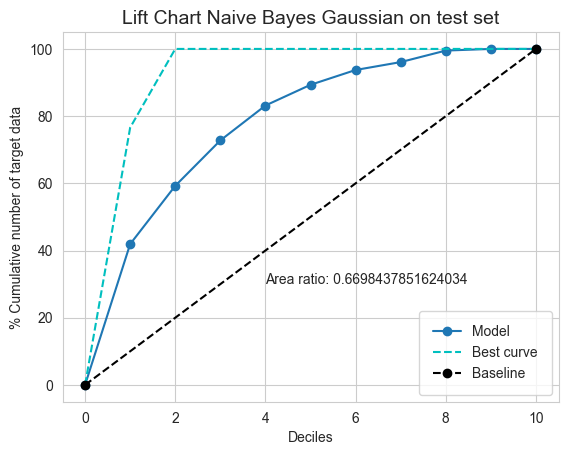

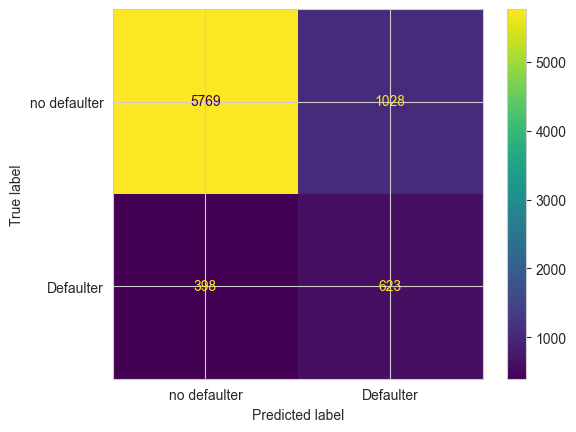

In [ ]:
# Instantiation of the naive Bayes (Gaussian) algorithm
nbg = GaussianNB()

# Train the model
nbg.fit(nbg_train, y)

# Predict proba & labels on the train data
train_pred = nbg.predict(nbg_train)
train_proba = nbg.predict_proba(nbg_train)

# Area ratio & accuracy on the train data
train_pcg = decile_table(y, train_proba[:, 1], labels=False)
area_ratio_train = area_ratio(train_pcg)
error_rate_train = 1 - accuracy_score(y, train_pred)

# Predict proba & labels on the test data
test_pred = nbg.predict(nbg_test)
test_proba = nbg.predict_proba(nbg_test)

# Area ratio & accuracy on the test data
test_pcg = decile_table(y_test, test_proba[:, 1], labels=False)
error_rate_test = 1 - accuracy_score(y_test, test_pred)
area_ratio_test = area_ratio(test_pcg)

print(f"Naive Bayes Gaussian error rate on train set (training): {error_rate_train} | Naive Bayes Gaussian area ratio on train set (training): {area_ratio_train}\n")
print(f"Naive Bayes Gaussian error rate on test (valid) set: {error_rate_test} | Naive Bayes Gaussian ratio on test (valid) set: {area_ratio_test} \n")

# Plot lift chart
plot_lift_chart(test_pcg, area_ratio_test, title='Lift Chart Naive Bayes Gaussian on test set')

# Confusion matrix
cm = confusion_matrix(y_test, test_pred, labels=nbg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['no defaulter', 'Defaulter'])
# Plot confusion matrix
disp.plot()

# Classification report
print(classification_report(y_test, test_pred, target_names=['No defaulter', 'Defaulter']))

# Random Forest Algorithm

In [ ]:
rf_train = X_train.copy() # Copy train data 
rf_test = X_test.copy() # Copy test data

### Feature engineering for article prepared data

In [ ]:
%%time
# Frequency encode
encode_FE(rf_train, rf_test, encode_aggregate_cols)
encode_AG(main_features, encode_aggregate_cols, ['mean', 'std'], rf_train, rf_test)

# impute missing values with -1 values
rf_train = rf_train.fillna(-1)
rf_test  = rf_test.fillna(-1)

C:\Users\Caxy\AppData\Local\Temp\ipykernel_4452\4205866885.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Caxy\AppData\Local\Temp\ipykernel_4452\4205866885.py:187: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Caxy\AppData\Local\Temp\ipykernel_4452\4205866885.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

CPU times: total: 1.27 s
Wall time: 1.63 s


C:\Users\Caxy\AppData\Local\Temp\ipykernel_4452\4205866885.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Caxy\AppData\Local\Temp\ipykernel_4452\4205866885.py:187: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Caxy\AppData\Local\Temp\ipykernel_4452\4205866885.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

### Prediction without CV

Random Forest error rate on train set (training): 0.09637101195044406 | Random Forest area ratio on train set (training): 0.896121279747951

Random Forest error rate on test (valid) set: 0.10232796111537479 | Random Forest area ratio on test (valid) set: 0.791069687195259 

              precision    recall  f1-score   support

No defaulter       0.91      0.98      0.94      6797
   Defaulter       0.70      0.38      0.49      1021

    accuracy                           0.90      7818
   macro avg       0.81      0.68      0.72      7818
weighted avg       0.88      0.90      0.88      7818

CPU times: total: 6min 49s
Wall time: 2min 2s


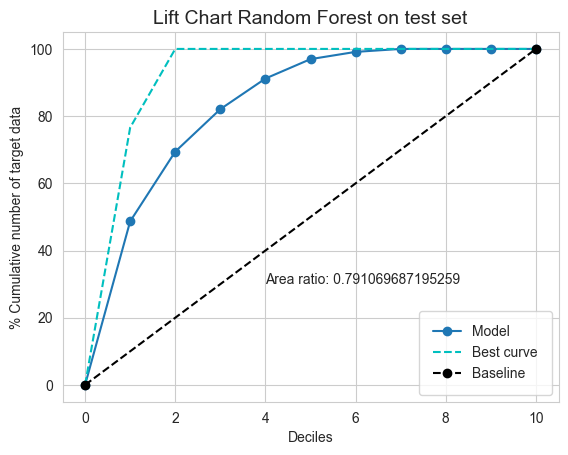

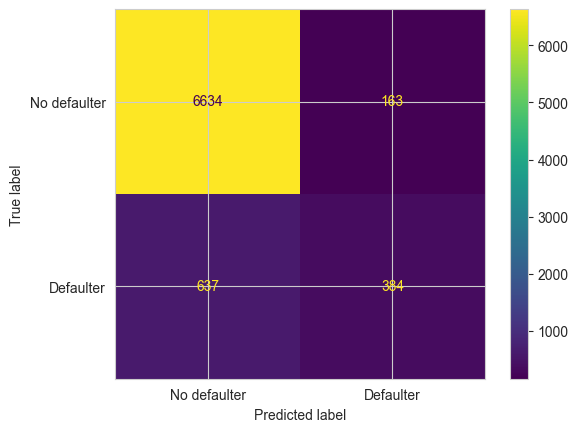

In [ ]:
%%time
rf = RandomForestClassifier(n_estimators=6000,
                            criterion='entropy',
                            min_samples_split=50,
                            min_samples_leaf=10,
                            max_depth=300,
                            n_jobs=-1,
                            random_state=43,
                            )
# Train the model
rf.fit(rf_train, y)

# Predict proba & labels on the train data
train_pred = rf.predict(rf_train)
train_proba = rf.predict_proba(rf_train)

# Area ratio & accuracy on the train data
train_pcg = decile_table(y, train_proba[:, 1], labels=False)
area_ratio_train = area_ratio(train_pcg)
error_rate_train = 1 - accuracy_score(y, train_pred)

# Predict proba & labels on the test data
test_pred12 = rf.predict(rf_test)
test_proba = rf.predict_proba(rf_test)

# Area ratio & accuracy on the test data
test_pcg = decile_table(y_test, test_proba[:, 1], labels=False)
error_rate_test = 1 - accuracy_score(y_test, test_pred12)
area_ratio_test = area_ratio(test_pcg)

print(f"Random Forest error rate on train set (training): {error_rate_train} | Random Forest area ratio on train set (training): {area_ratio_train}\n")
print(f"Random Forest error rate on test (valid) set: {error_rate_test} | Random Forest area ratio on test (valid) set: {area_ratio_test} \n")

# Plot lift chart
plot_lift_chart(test_pcg, area_ratio_test, title='Lift Chart Random Forest on test set')

# Confusion matrix
cm = confusion_matrix(y_test, test_pred12, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['No defaulter', 'Defaulter'])
disp.plot()
print(classification_report(y_test, test_pred12, target_names=['No defaulter', 'Defaulter']))

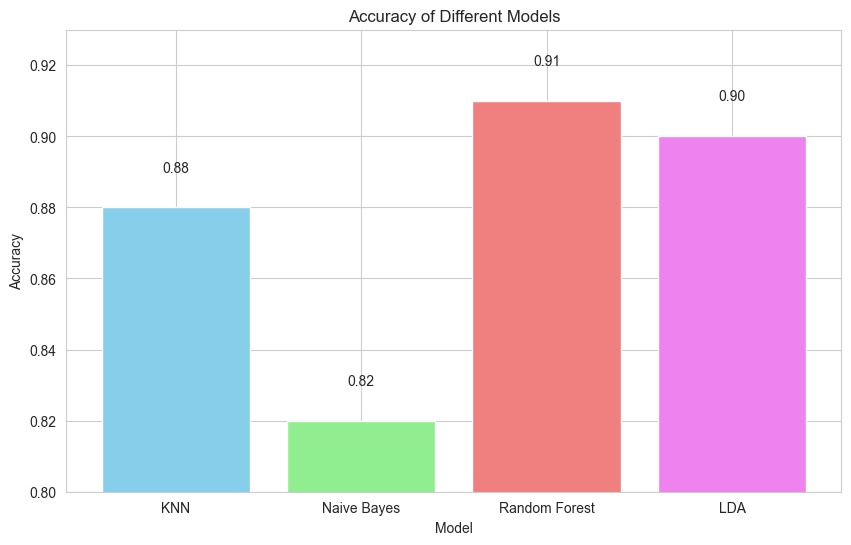

In [ ]:
models = ['KNN', 'Naive Bayes', 'Random Forest', 'LDA']

# Accuracy of each model
accuracy = [0.88, 0.82, 0.91, 0.90]  # Assuming RNN accuracy as 98% for demonstration

plt.figure(figsize=(10, 6))
plt.bar(models, accuracy, color=['skyblue', 'lightgreen', 'lightcoral', 'violet'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.ylim(0.80, 0.93)
for i, acc in enumerate(accuracy):
    plt.text(i, acc + 0.01, f'{acc:.2f}', ha = 'center')

plt.show()